# Libraries

In [4]:
# import libraries
library(tidyverse)
library(caret)
library(corrplot)
library(reshape2)
library(gridExtra)
library(leaps)
library('ggpubr')
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'caret' was built under R version 4.3.2"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'corrplot' was built under R version 4.3.3"
corrplot 0.92 loaded

Warning message:
"package 'reshape2' was built under R version 4.3.2"

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching packag

# Data

In [5]:
# read in dataset
# from https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012
df <- read_csv('data/baseball.csv')

Rows: 1232 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Team, League
dbl (13): Year, RS, RA, W, OBP, SLG, BA, Playoffs, RankSeason, RankPlayoffs,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Functions

In [6]:
# single calculation mspe function
model_mspe <- function(test_data, response_var, glmod, threshold=0.5) {
    # gather observations respective to response variable
    obs <- test_data[[response_var]]
    # get probabilities given input
    pred_probs <- predict(glmod, test_data, 'response')
    # turn probabilities into values given the threshold (default=0.5)
    pred <- ifelse(pred_probs > 0.5, 1, 0)
    # calculate mean squared prediction error (mspe)
    mspe <- mean((obs - pred)^2)
    return(mspe)
}

In [7]:
# function for making dataframe long with respect to response variable
create_long_df <- function(df, response) {
    df_long <- pivot_longer(df,
                            cols = names(df %>% select(-all_of(response))),
                            names_to = 'feature_names',
                            values_to = 'feature_values')
    return(df_long)
}

In [8]:
# create function for faceted plots
plot_long_facets <- function(df_long, subset_type, response) {
    title_text <- paste(subset_type, response)
    ggplot(df_long, aes(x=feature_values, y=!!sym(response))) +
        geom_point() +
        facet_wrap(~ feature_names, scales = 'free_x') +
        ggtitle(title_text) +
        xlab('Feature')
}

In [9]:
# function for plotting GLM results
plot_glm <- function(full_data, train_data, test_data, response_var, subset_type, threshold=0.5) {
    # backwards selection results table
    bs_results <- backwards_glm(train_data=train_data, test_data=test_data, response_var=response_var)
    
    # long df for plotting facets
    df_long <- create_long_df(full_data, response_var)
    
    # facets plot
    facets_plot <- plot_long_facets(df_long, subset_type=subset_type, response=response_var)
    
    # AIC plot
    x <- 1:dim(bs_results)[1]
    AIC_plot <- ggplot(data=bs_results, aes(x=x, y=AIC)) +
        geom_line() +
        geom_point(aes(x=which.min(AIC), y=min(AIC)), color='red', size=3) +
        xlab('Model') +
        theme(aspect.ratio=1)
    
    # MSPE plot
    MSPE_plot <- ggplot(data=bs_results, aes(x=x, y=MSPE)) +
        geom_line() +
        geom_point(aes(x=which.min(MSPE), y=min(MSPE)), color='red', size=3) +
        xlab('Model') +
        theme(aspect.ratio=1)
    
    # combine AIC and MSPE into single plot
    metrics_plot <- ggarrange(AIC_plot, MSPE_plot,
                              labels = c('AIC', 'MSPE'))
    
    # print results
    print(bs_results)
    print(facets_plot)
    print(metrics_plot)
}

In [10]:
# backwards selection to return several important metrics
backwards_glm <- function(train_data, test_data, response_var, threshold=0.5) {
    # full model
    formula <- paste(response_var, '~ .', '')
    glmod_full <- glm(data = train_data, as.formula(formula), family = binomial)
    # pvals
    pvals <- summary(glmod_full)$coefficients[, 4]
    # feature consideration
    features <- names(pvals)
    features <- features[features != '(Intercept)']
    
    # using deviance
    # null deviance - residual deviance, null residual df - residual deviance df
    # null hypothesis: the model is not useful
    # alternative hypothesis: the model is useful
    dev = 1 - pchisq(glmod_full$null.deviance - glmod_full$deviance,
                     glmod_full$df.null - glmod_full$df.residual)
    
    # dataframe
    results_df <- data.frame(t(sapply(pvals, 'c')),
                             AIC=AIC(glmod_full),
                             DevDiffX2 = dev,
                             Ftest = NA,
                             MSPE=model_mspe(test_data=test_data, response_var=response_var, glmod=glmod_full))
    
    # set glmod_full to glmod for following loop
    glmod <- glmod_full
    
    # go until last feature remains
    while (length(features) > 1) {
        # remove value with max pvalue (intercept is removed in case)
        remove_feature <- names(which.max(unlist(pvals)))
        # create text formula for update() function
        formula <- paste('.~.-', remove_feature)
        # update glm with as.formula() function
        glmod <- update(glmod, as.formula(formula))
        # pvals
        pvals <- summary(glmod)$coefficients[, 4]
        dev = 1 - pchisq(glmod$null.deviance - glmod$deviance,
                         glmod$df.null - glmod$df.residual)
        # new row for dataframe
        new_df <- data.frame(t(sapply(pvals, 'c')),
                             AIC=AIC(glmod), 
                             DevDiffX2 = dev,
                             Ftest=anova(glmod_full, glmod, test='Chisq')[2,5],
                             MSPE=model_mspe(test_data=test_data, response_var=response_var, glmod=glmod))
        # update feature consideration
        features <- names(pvals)
        # remove intercept from features to be considered for removal
        features <- na.omit(features[features != '(Intercept)'])
        # update dataframe
        results_df <- bind_rows(results_df, new_df)
    }
    
    # round all numbers, rename intercept column
    results_df <- results_df %>%
        mutate_if(is.numeric, round, digits=3) %>%
        rename(Int. = X.Intercept.)

    # return ending backwards selection dataframe
    return(results_df)
}

In [11]:
diagnostics_plots <- function(df, model, response_var, type='linear') {
    # default plots
    plot(model)
    
    # if linear
    if (type=='linear') {
        plot(predict(model), df[[response_var]])
    # if response
    } else  if (type=='response') {
        plot(predict(model, type='response'), df[[response_var]])
    } else {
        print('Please use either type: linear or type: response')
    }
    
    
    # successive residuals
    df_diagnostics = data.frame(yhat = fitted(model), r = resid(model), y = df[[response_var]])

    n = dim(df)[1]; 
    x = head(df_diagnostics$r, n-1)
    y = tail(df_diagnostics$r, n-1)
    srp = data.frame(x,y)
    ggplot(srp, aes(x = x, y = y)) + 
        geom_point() + 
        geom_vline(xintercept = 0) + 
        geom_hline(yintercept = 0) + 
        xlab(expression(hat(epsilon)[i])) +
        ylab(expression(hat(epsilon)[i+1])) + 
        ggtitle("Successive Residual Plot") + 
        theme_bw() + 
        theme(plot.title = element_text(hjust = 0.5)) 
    }

# Clean Data

In [12]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
# print(col_na)
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
# print(break_na)
# summarize break_na
summary(break_na)
season_break <- max(break_na)
# print(season_break)

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

In [13]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [14]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [15]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [16]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [17]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [18]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

In [19]:
# full dataset for modeling
df_full_playoffs <- df_full %>% select(-c(Year, League, Champion))
df_full_champion <- df_full %>% select(-c(Year, League, Playoffs))
# recent dataset for modeling
df_recent_playoffs <- df_recent %>% select(-c(Year, League, Champion))
df_recent_champion <- df_recent %>% select(-c(Year, League, Playoffs))

In [20]:
# train/test split for full data
set.seed(42)
n = floor(0.8 * nrow(df_full)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_full)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_full_playoffs = df_full_playoffs[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full_playoffs = df_full_playoffs[-index, ] #set the testing set to be the remaining rows
# champions
train_full_champion = df_full_champion[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full_champion = df_full_champion[-index, ] #set the testing set to be the remaining rows

In [21]:
# train/test split for recent data
set.seed(42)
n = floor(0.8 * nrow(df_recent)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_recent)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_recent_playoffs = df_recent_playoffs[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent_playoffs = df_recent_playoffs[-index, ] #set the testing set to be the remaining rows
# champions
train_recent_champion = df_recent_champion[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent_champion = df_recent_champion[-index, ] #set the testing set to be the remaining rows

# Model Selection

  Int.   OBP   SLG    BA WP    RD     AIC DevDiffX2 Ftest  MSPE
1    0 0.267 0.009 0.524  0 0.753 420.491         0    NA 0.077
2    0 0.280 0.009 0.522  0    NA 418.590         0 0.753 0.073
3    0 0.383 0.011    NA  0    NA 417.000         0 0.775 0.073
4    0    NA 0.000    NA  0    NA 415.762         0 0.736 0.073
5    0    NA    NA    NA  0    NA 435.896         0 0.000 0.057


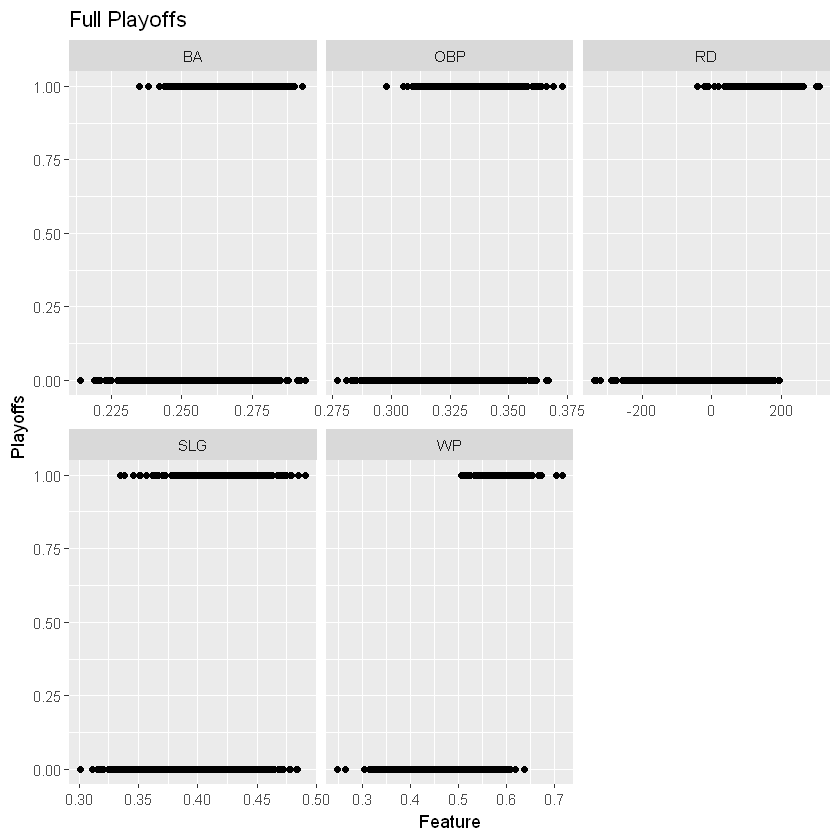

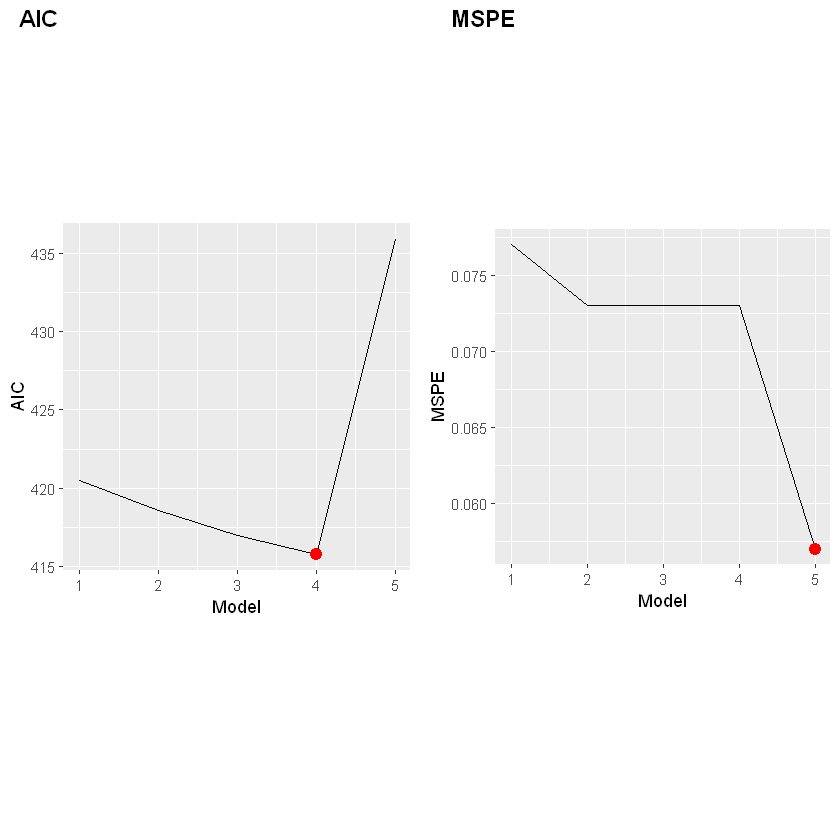

In [22]:
# full dataset - playoffs
plot_glm(df_full_playoffs, train_full_playoffs, test_full_playoffs, 'Playoffs', 'Full')

## Full Dataset - Playoffs

- AIC reports Model 4 as the best model (minimum) and has a rapid incline to Model 5
- MSPE reports Model 5 as the best model (minimum), but Model 4 still has a reasonable MSPE
- However, the F-test for Model 5 indicates that the model is not sufficient

Therefore, it's reasonable to use Model 4 as our *best* model, with the features:

- SLG
- WP

In [23]:
glmod_full_playoffs <- glm(data=train_full_playoffs, Playoffs~SLG+WP, family=binomial)
summary(glmod_full_playoffs)


Call:
glm(formula = Playoffs ~ SLG + WP, family = binomial, data = train_full_playoffs)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -39.916      3.254 -12.268  < 2e-16 ***
SLG           19.388      4.245   4.567 4.95e-06 ***
WP            56.429      4.572  12.343  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 988.56  on 984  degrees of freedom
Residual deviance: 409.76  on 982  degrees of freedom
AIC: 415.76

Number of Fisher Scoring iterations: 7


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


  Int.   OBP   SLG    BA WP  RD     AIC DevDiffX2 Ftest  MSPE
1    0 0.340 0.156 0.101  0 0.7 113.492         0    NA 0.036
2    0 0.298 0.162 0.111  0  NA 111.640         0 0.700 0.036
3    0    NA 0.072 0.212  0  NA 110.744         0 0.535 0.036
4    0    NA 0.174    NA  0  NA 110.300         0 0.422 0.032
5    0    NA    NA    NA  0  NA 110.236         0 0.315 0.032


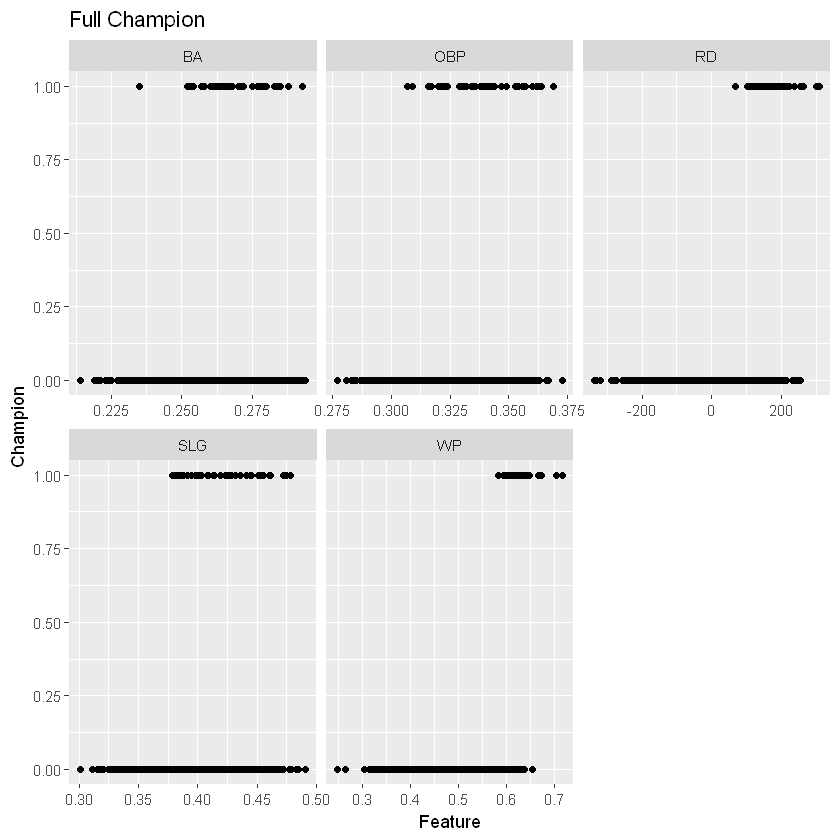

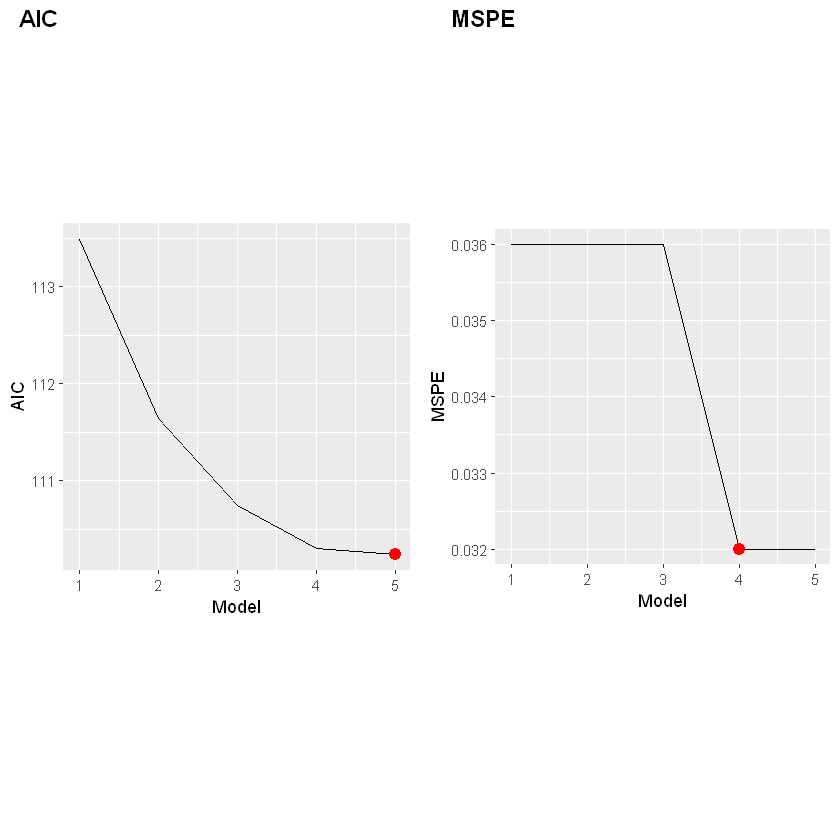

In [24]:
# full dataset - champions
plot_glm(df_full_champion, train_full_champion, test_full_champion, 'Champion', 'Full')

## Full Dataset - Champion

- AIC reports Model 5 as the best model (minimum)
- MSPE reports Model 4 as the best model (minimum), however it was reported as the first minimum while Model 5 has the same MSPE
- The F-test for Model 5 confirms the reduced model is sufficient

Therefore, it's reasonable to use Model 5 as our *best* model, with the feature:

- WP

In [25]:
glmod_full_champion <- glm(data=train_full_champion, Champion~WP, family=binomial)
summary(glmod_full_champion)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = Champion ~ WP, family = binomial, data = train_full_champion)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -56.631      7.983  -7.094 1.30e-12 ***
WP            91.247     13.092   6.969 3.18e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 328.30  on 984  degrees of freedom
Residual deviance: 106.24  on 983  degrees of freedom
AIC: 110.24

Number of Fisher Scoring iterations: 10


  Int.   OBP   SLG   BA WP    RD  OOBP  OSLG     AIC DevDiffX2 Ftest  MSPE
1    0 0.398 0.208 0.67  0 0.313 0.636 0.608 127.333         0    NA 0.071
2    0 0.465 0.144   NA  0 0.321 0.546 0.639 125.515         0 0.670 0.083
3    0 0.328 0.160   NA  0 0.203 0.462    NA 123.734         0 0.818 0.083
4    0 0.116 0.228   NA  0 0.072    NA    NA 122.279         0 0.814 0.071
5    0 0.290    NA   NA  0 0.069    NA    NA 121.804         0 0.650 0.083
6    0    NA    NA   NA  0 0.115    NA    NA 120.944         0 0.607 0.071
7    0    NA    NA   NA  0    NA    NA    NA 121.513         0 0.403 0.071


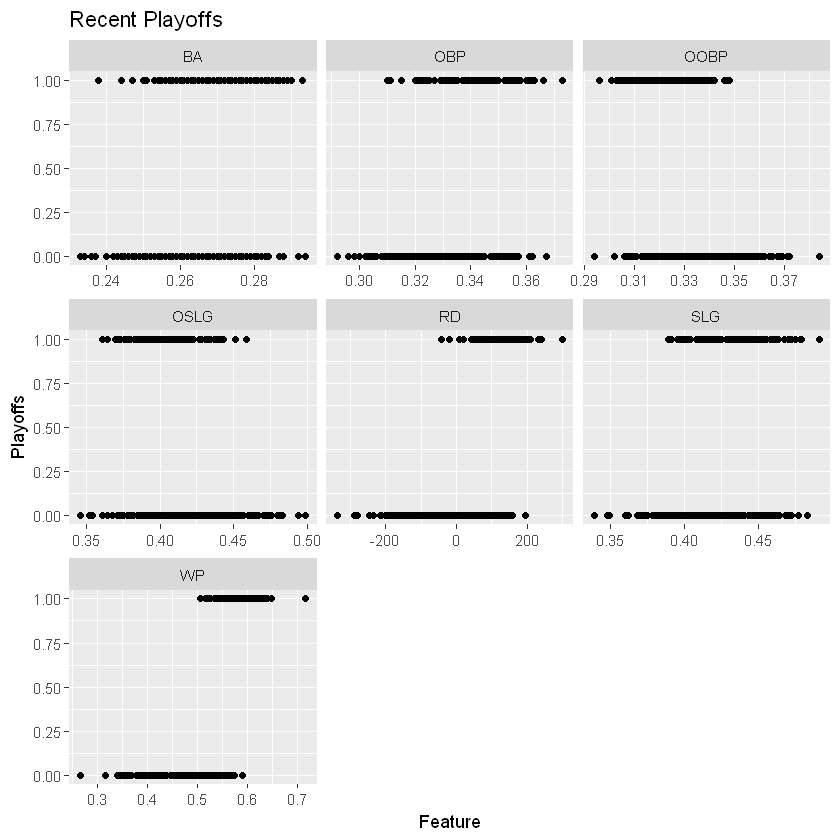

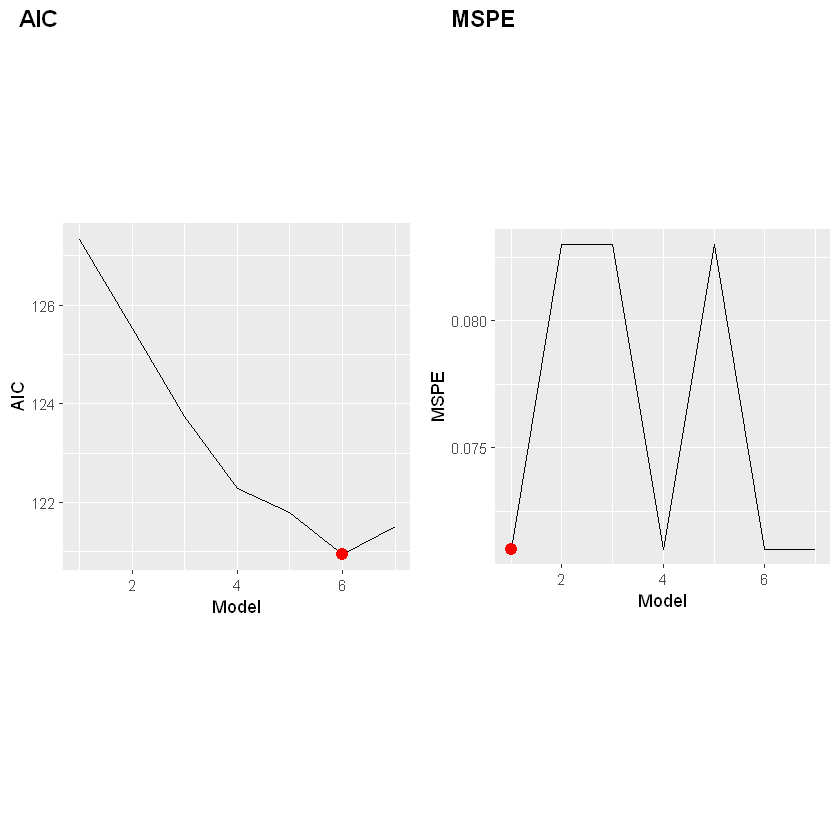

In [26]:
# recent dataset - playoffs
plot_glm(df_recent_playoffs, train_recent_playoffs, test_recent_playoffs, 'Playoffs', 'Recent')

## Recent Dataset - Playoffs

- AIC reports Model 6 as the best model (minimum)
- MSPE reports Model 1 as the best model (minimum), however it was reported as the first minimum while Model 4, 6, and 7 each have the same MSPE
- The F-test for Model 6 confirms the reduced model is sufficient

Therefore, it's reasonable to use Model 6 as our *best* model, with the features:

- WP
- RD

However, it is worth noting that **RD**, although statistically significant, the coefficent (-0.01) has a rather minimal effect.

In [27]:
glmod_recent_playoffs <- glm(data=train_recent_playoffs, Playoffs~WP+RD, family=binomial)
summary(glmod_recent_playoffs)


Call:
glm(formula = Playoffs ~ WP + RD, family = binomial, data = train_recent_playoffs)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -54.985543   9.123310  -6.027 1.67e-09 ***
WP          100.989782  17.268945   5.848 4.97e-09 ***
RD           -0.011562   0.007336  -1.576    0.115    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 390.51  on 335  degrees of freedom
Residual deviance: 114.94  on 333  degrees of freedom
AIC: 120.94

Number of Fisher Scoring iterations: 8


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


   Int.   OBP   SLG    BA    WP    RD  OOBP  OSLG    AIC DevDiffX2 Ftest  MSPE
1 0.053 0.614 0.342 0.819 0.001 0.407 0.340 0.430 54.569         0    NA 0.048
2 0.036 0.533 0.219    NA 0.001 0.422 0.341 0.430 52.620         0 0.820 0.048
3 0.039    NA 0.165    NA 0.001 0.553 0.456 0.518 51.014         0 0.800 0.048
4 0.042    NA 0.195    NA 0.001    NA 0.501 0.651 49.372         0 0.849 0.048
5 0.032    NA 0.221    NA 0.000    NA 0.285    NA 47.581         0 0.908 0.048
6 0.000    NA 0.500    NA 0.000    NA    NA    NA 46.751         0 0.823 0.060
7 0.000    NA    NA    NA 0.000    NA    NA    NA 45.208         0 0.853 0.060


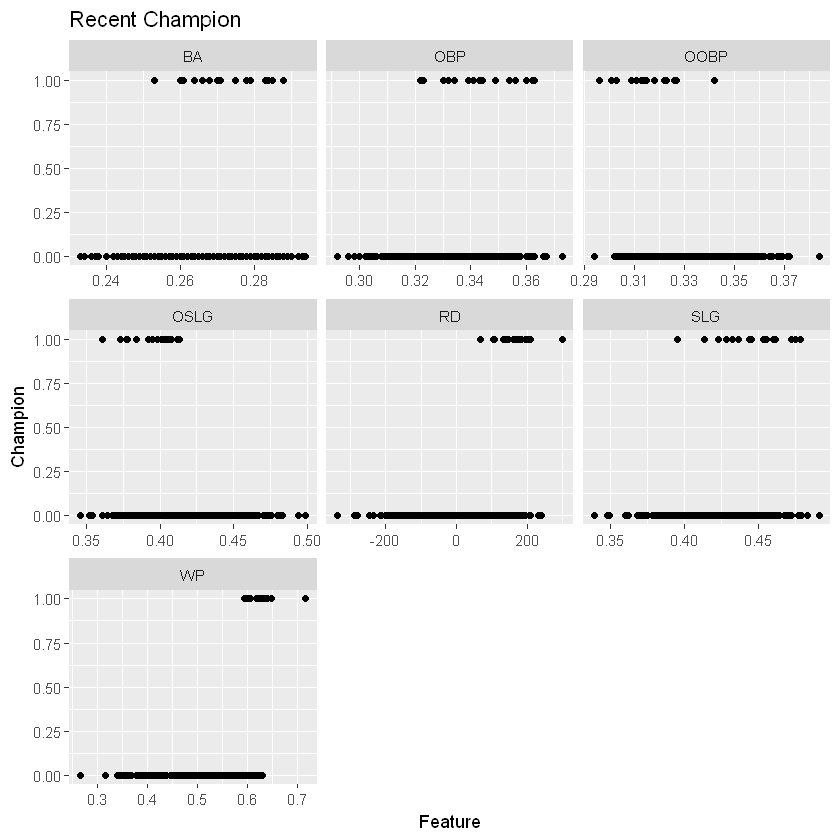

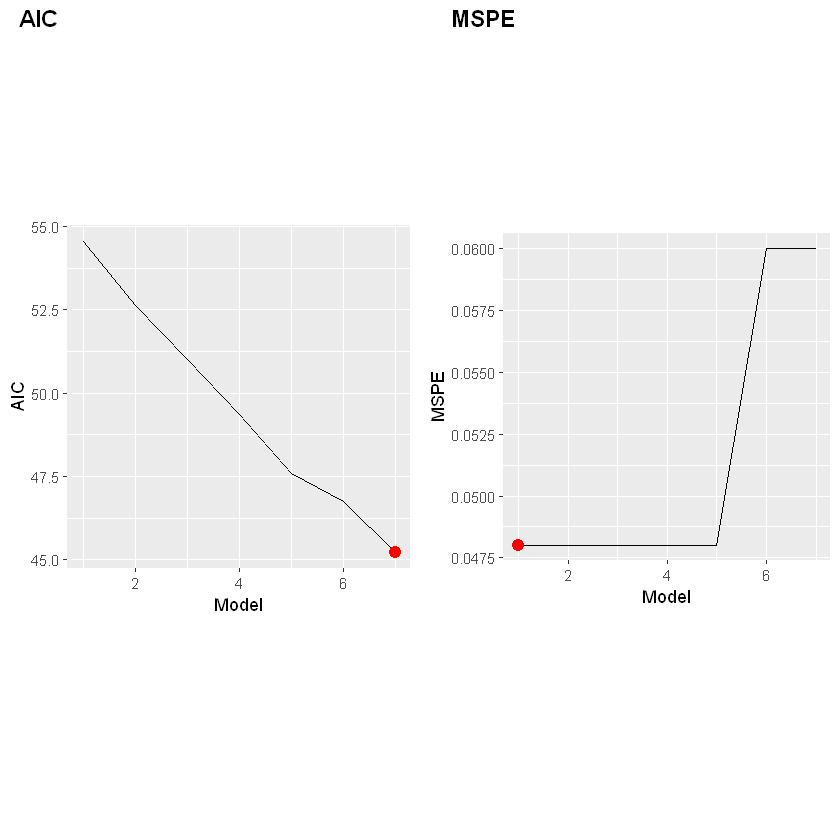

In [28]:
# recent dataset - champion
plot_glm(df_recent_champion, train_recent_champion, test_recent_champion, 'Champion', 'Recent')

## Recent Dataset - Champion

- AIC reports Model 7 as the best model (minimum)
- MSPE reports Model 1 as the best model (minimum), however it was reported as the first minimum while Model 2, 3, 4, and 5 each have the same MSPE. Model 6 and 7 have the same MSPE which is only slightly higher than the other models.
- The F-test confirms all models are acceptable

Therefore, it's reasonable to use Model 7 as our *best* model, with the feature:

- WP

In [29]:
glmod_recent_champion <- glm(data=train_recent_champion, Champion~WP, family=binomial)
summary(glmod_recent_champion)


Call:
glm(formula = Champion ~ WP, family = binomial, data = train_recent_champion)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -51.77      12.07  -4.288 1.81e-05 ***
WP             83.13      19.88   4.182 2.89e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 103.539  on 335  degrees of freedom
Residual deviance:  41.208  on 334  degrees of freedom
AIC: 45.208

Number of Fisher Scoring iterations: 9


# Commentary

**The table printout:**

- Columns used in backwards selection reports the p-value `t-test: hypothesis_test_1` for each feature retained each round, and reports how statistically significant the feature is for a model:
    - OBP
    - SLG
    - BA
    - WP
    - RD
    - OOBP (recent data only)
    - OSLG (recent data only)
- AIC (Akaike Information Criterion) `AIC: formula_1` reports the AIC for each round, which evalutes how well a model fits the data, and is moreso only meaningful when comparing between models.
- DevDiffX2: `chi-squared t-test: hypothesis_test_2` reports a p-value on how useful a model by comparing the *null deviance* to the *residual deviance*.
- F-test: `partial-f-test: hypothesis_test_3` reports if a reduced model is sufficient (compared to the full model).
- MSPE (mean squared prediction error): `MSPE: formula_3` is a measure of accuracy, comparing predictions to observations.

**The plots:**

The faceted plots show the binomial result compared to each feature in the dataset, while the AIC and MSPE plots are shown for aiding in model selection.

In [30]:
print('Full Dataset - Playoffs')
glmod_full_playoffs$coefficients
print('Full Dataset - Champion')
glmod_full_champion$coefficients
print('Recent Dataset - Playoffs')
glmod_recent_playoffs$coefficients
print('Recent Dataset - Champion')
glmod_recent_champion$coefficients

[1] "Full Dataset - Playoffs"


(Intercept)         SLG          WP 
  -39.91644    19.38785    56.42861

[1] "Full Dataset - Champion"


(Intercept)          WP 
  -56.63104    91.24658

[1] "Recent Dataset - Playoffs"


(Intercept)           WP           RD 
-54.98554330 100.98978228  -0.01156155

[1] "Recent Dataset - Champion"


(Intercept)          WP 
  -51.76871    83.12767

**Playoffs**

- For the full dataset, we have the systematic component: $\eta = -39.92 + 19.39 SLG + 56.43 WP$
- For the recent dataset, we have the systematic component: $\eta = -54.99 + 100.99 WP - 0.01 RD$

**Champion**

- For the full dataset, we have the systematic component: $\eta = -56.63 + 91.25 WP$
- For the recent dataset, we have the systematic component: $\eta = -51.77 + 83.13 WP$

Although all the **Playoffs** and **Champion** best models end with features (stats tracked) which are available across all time periods, the models for **Playoffs** across both are significantly different while the models for **Champion** are relatively similar. If it wasn't for the F-test in 

Therefore, there is evidence warranting differences across time periods for predicting a team making the **Playoffs**, however a team winning, i.e. becoming a **Champion** seem relatively stable across time periods.

# Diagnostics

## Plots

- Residuals vs. Fitted (constant variance assumption)
- QQ-Plot (normality assumption)
- Residuals vs. Leverage (outliers)
- Predicted vs. Observed (linearity assumption)
- Successive Residual Plot (independence assumption)

## Hypothesis Tests

- Shapiro-Wilk Normality Test (normality assumption)
- Durbin-Watson Test (autocorrelation of residuals - independence assumption)

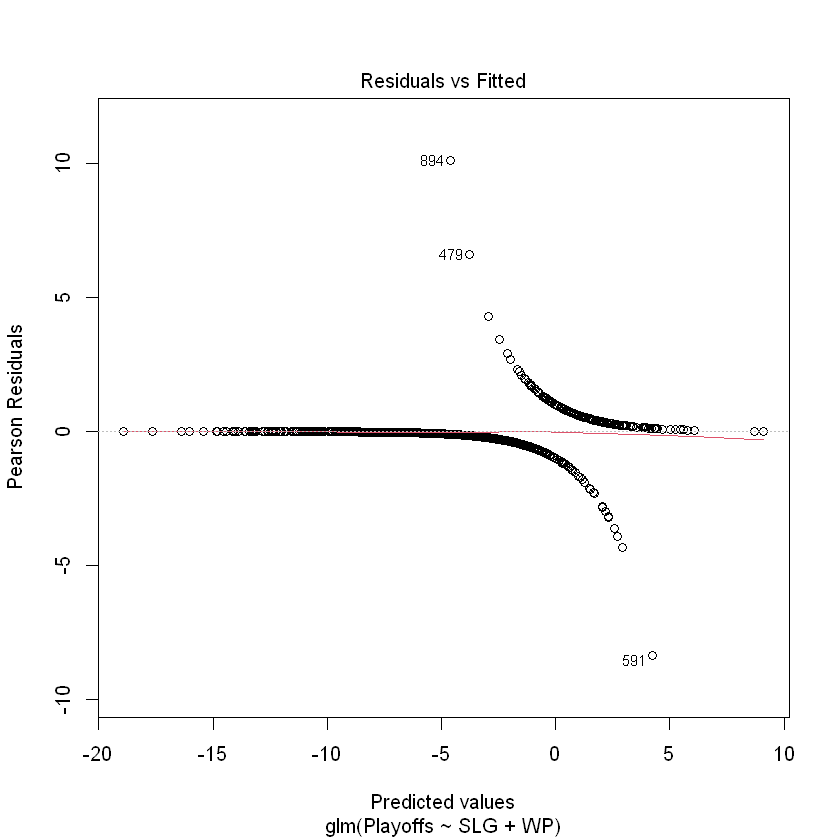

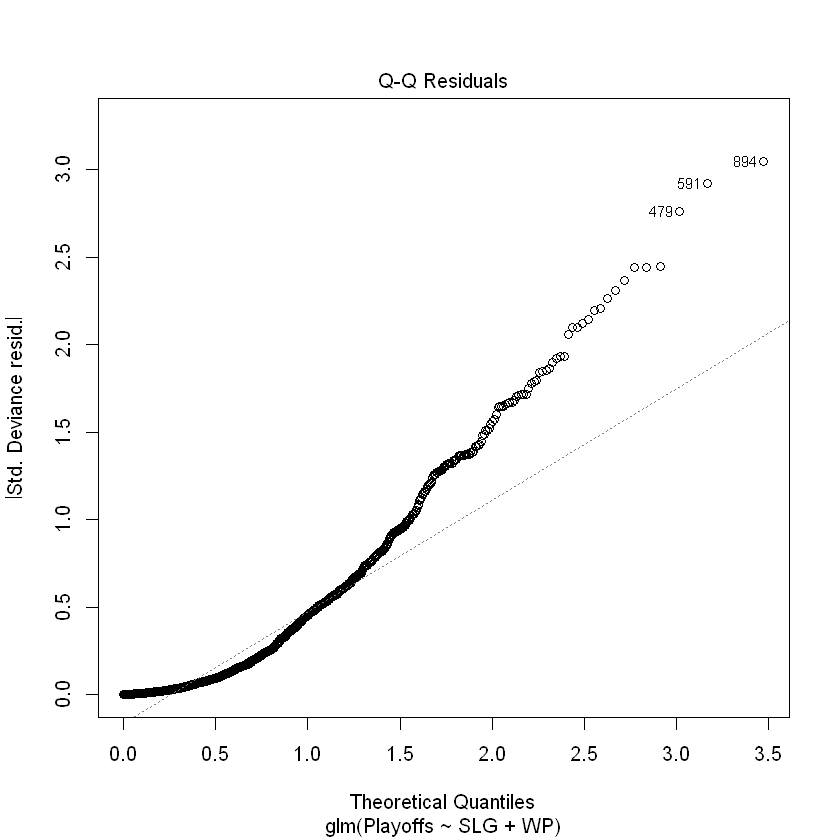

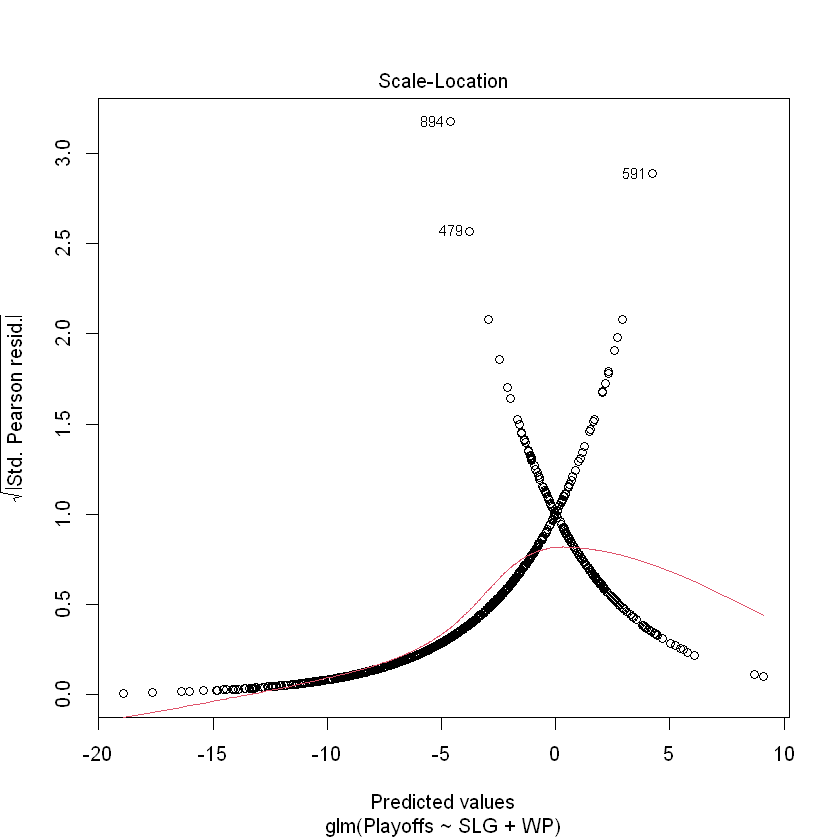

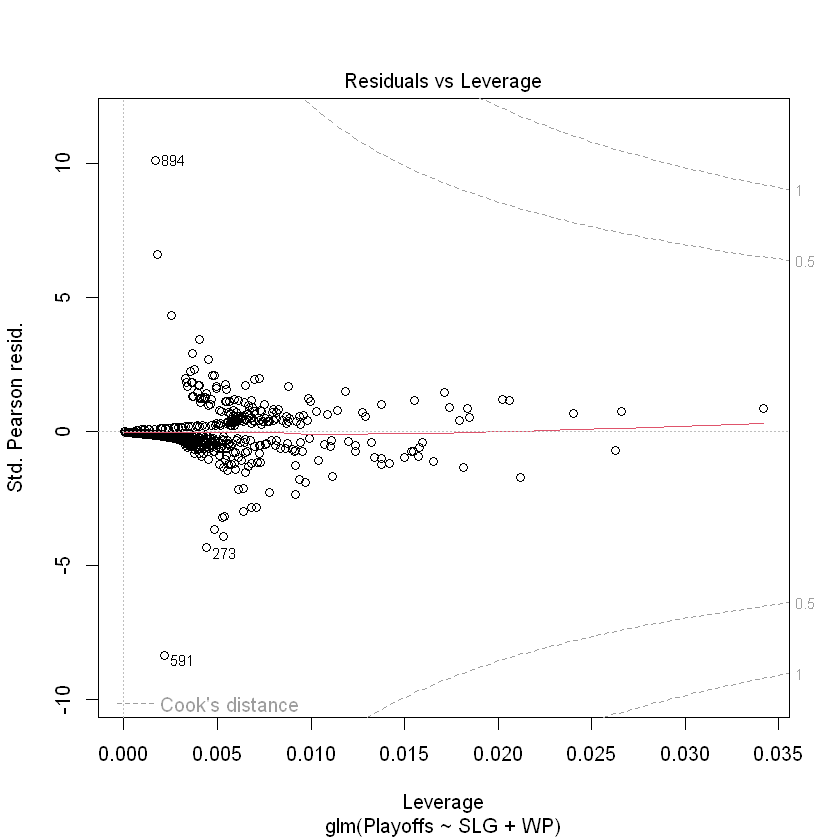

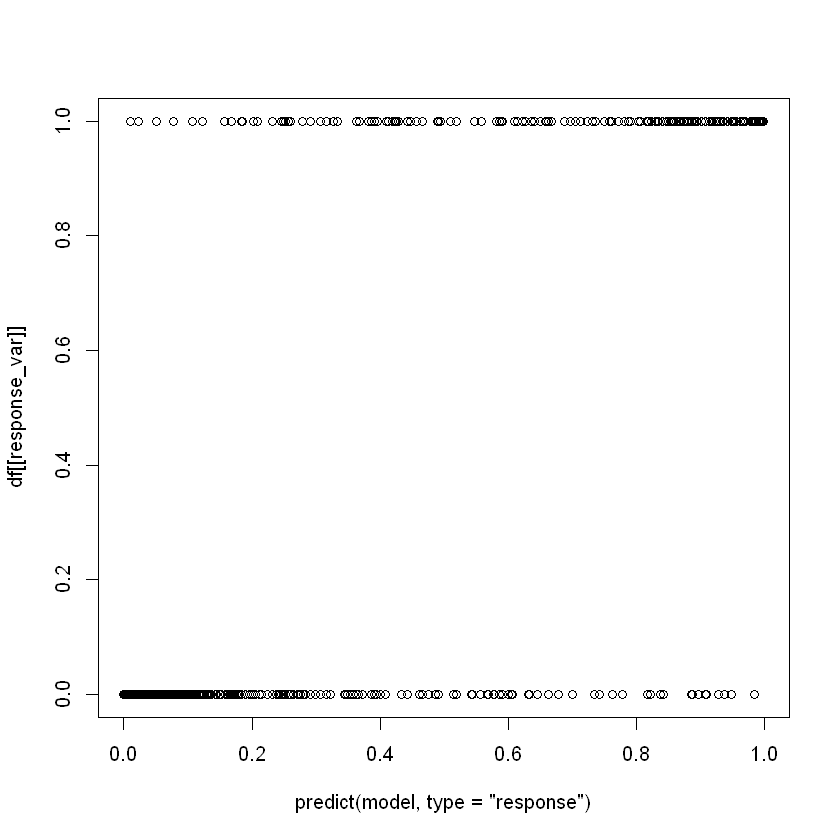

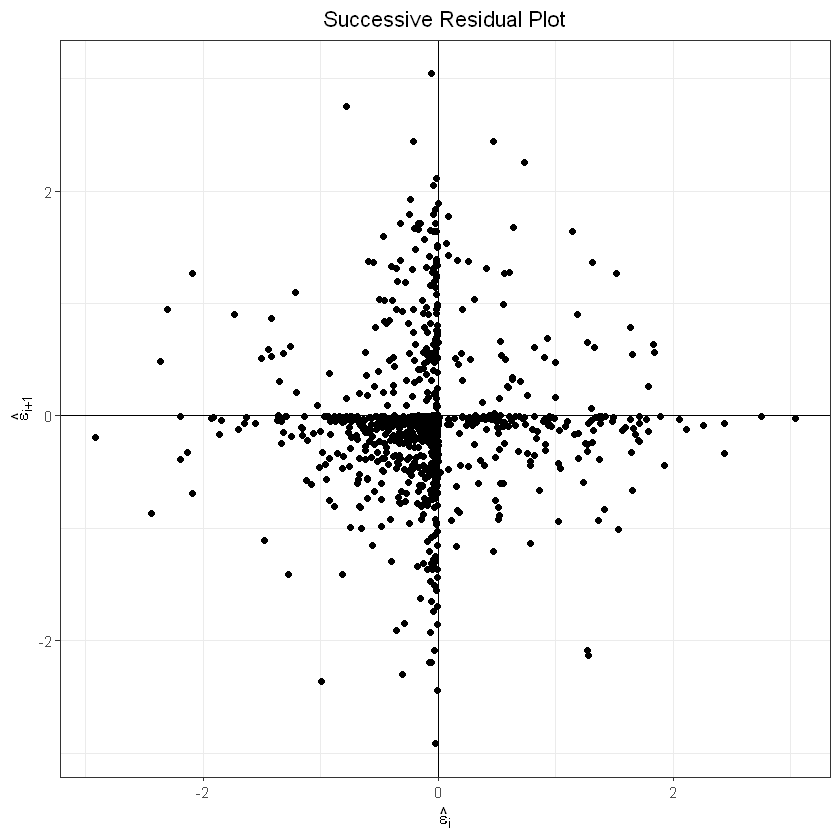

In [31]:
# full dataset - playoffs
diagnostics_plots(df=train_full_playoffs, model=glmod_full_playoffs, response_var='Playoffs', type='response')

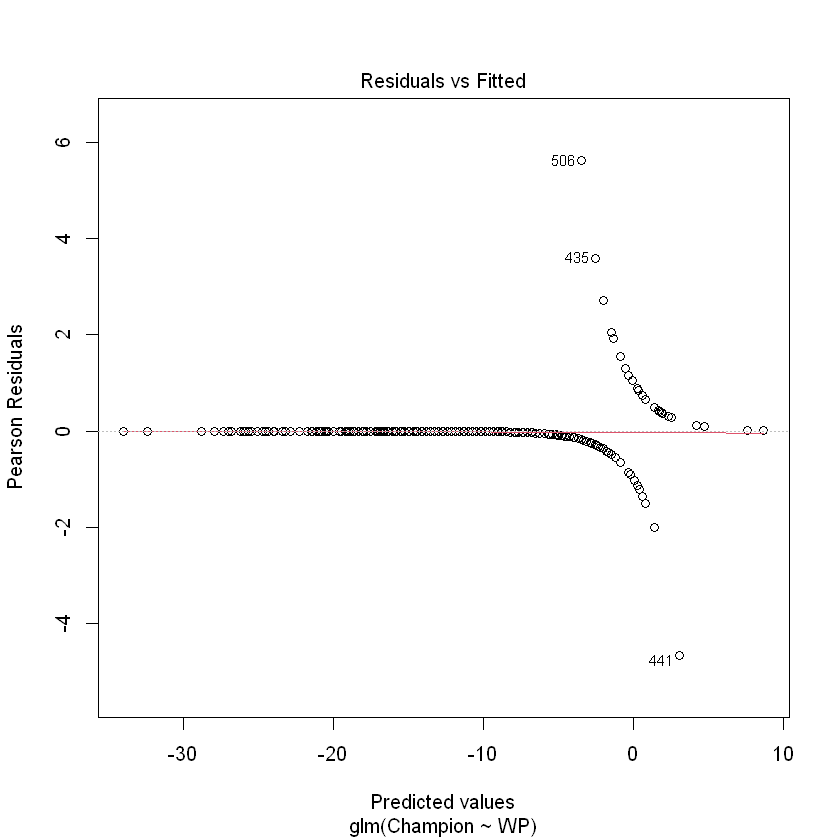

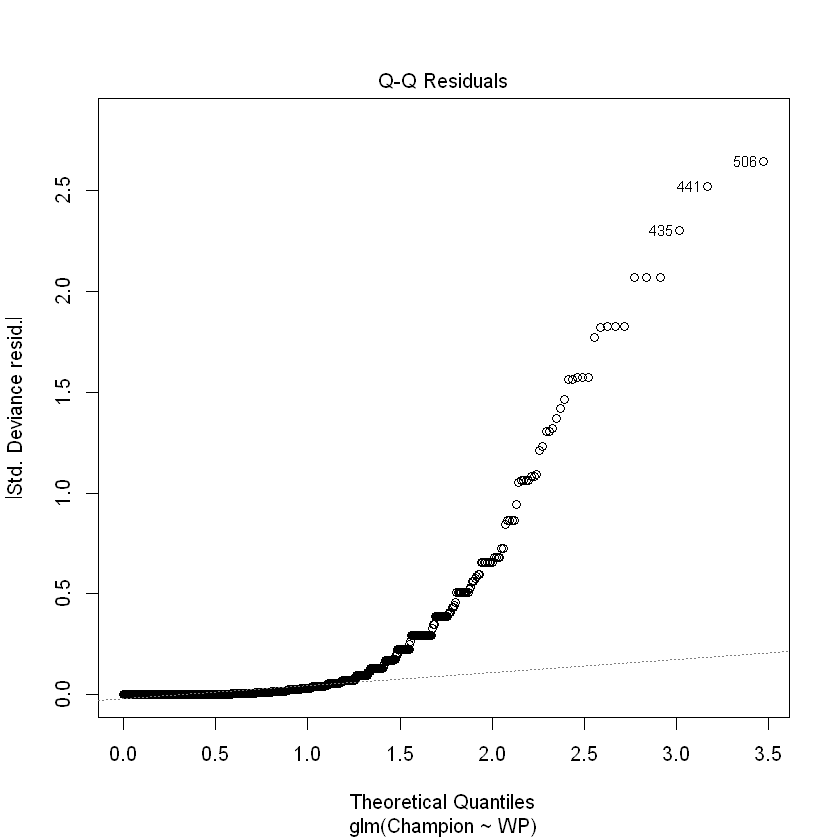

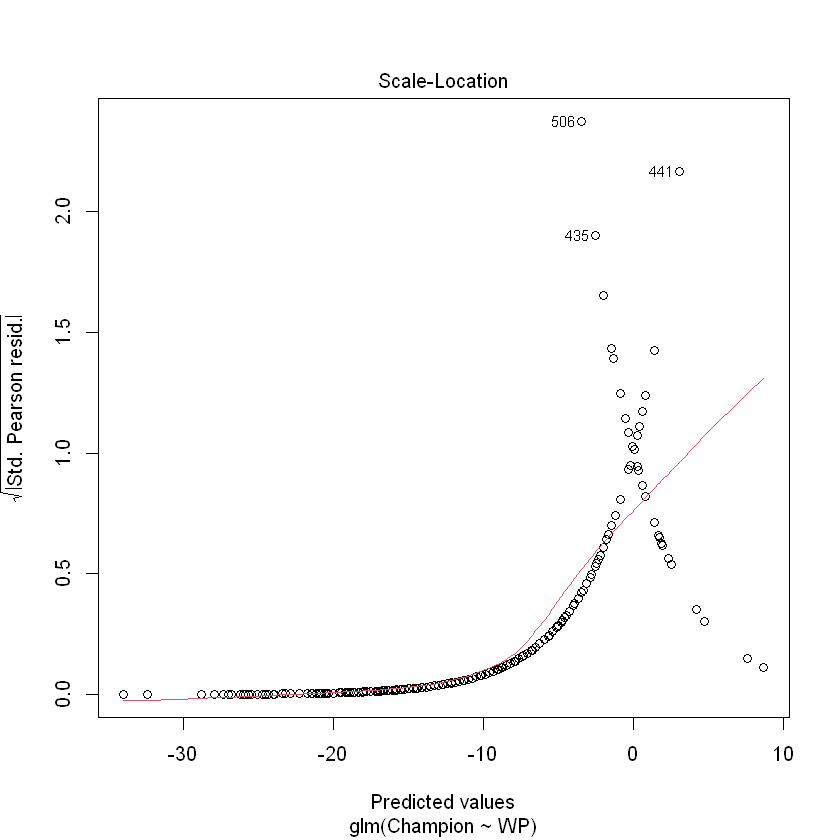

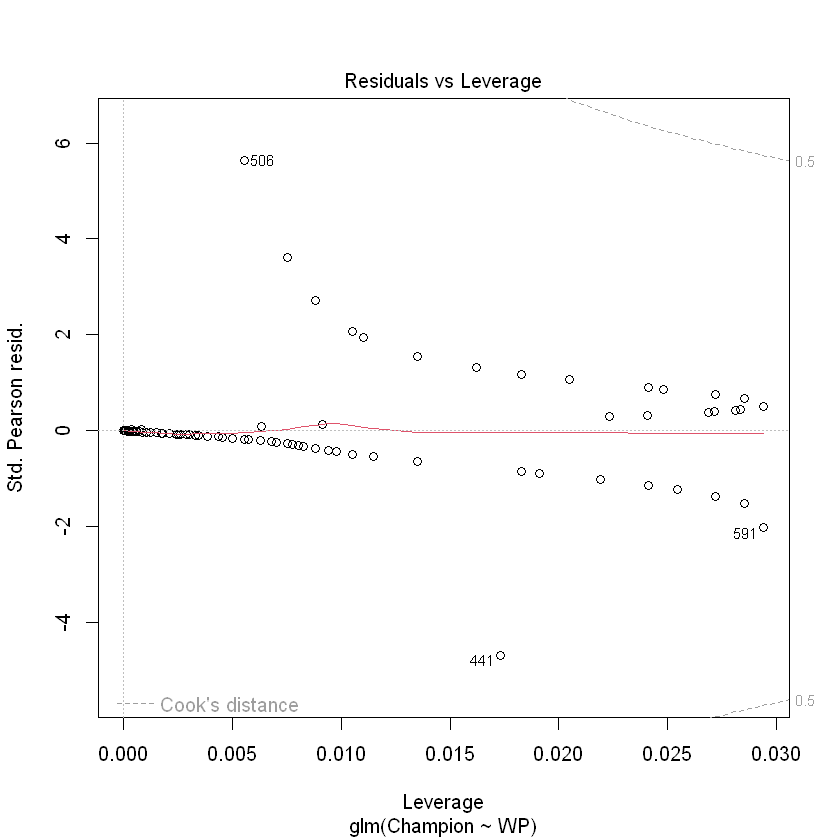

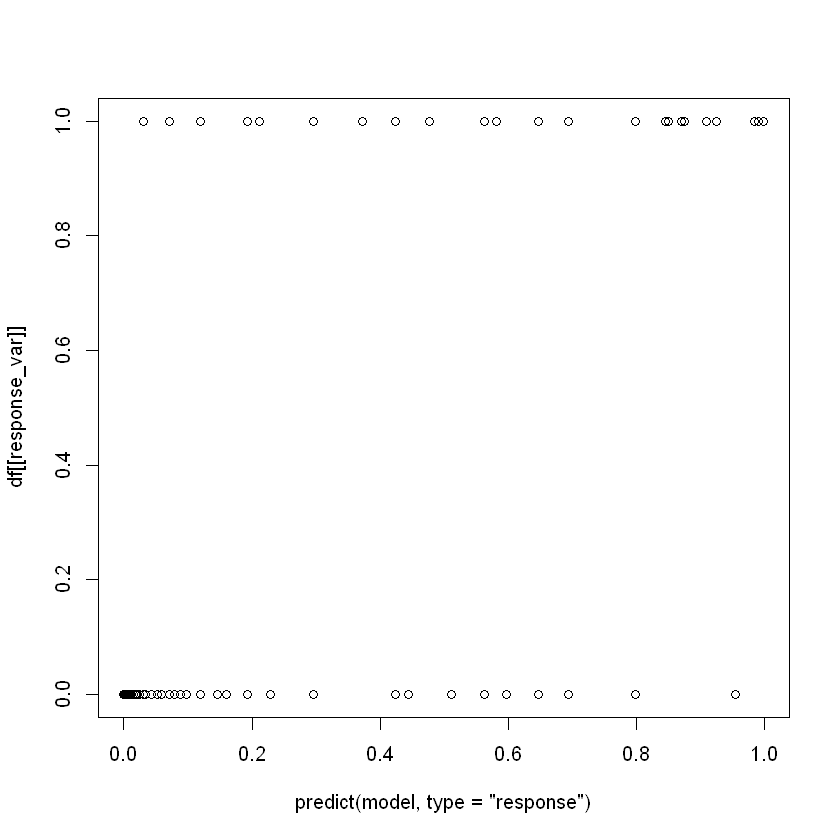

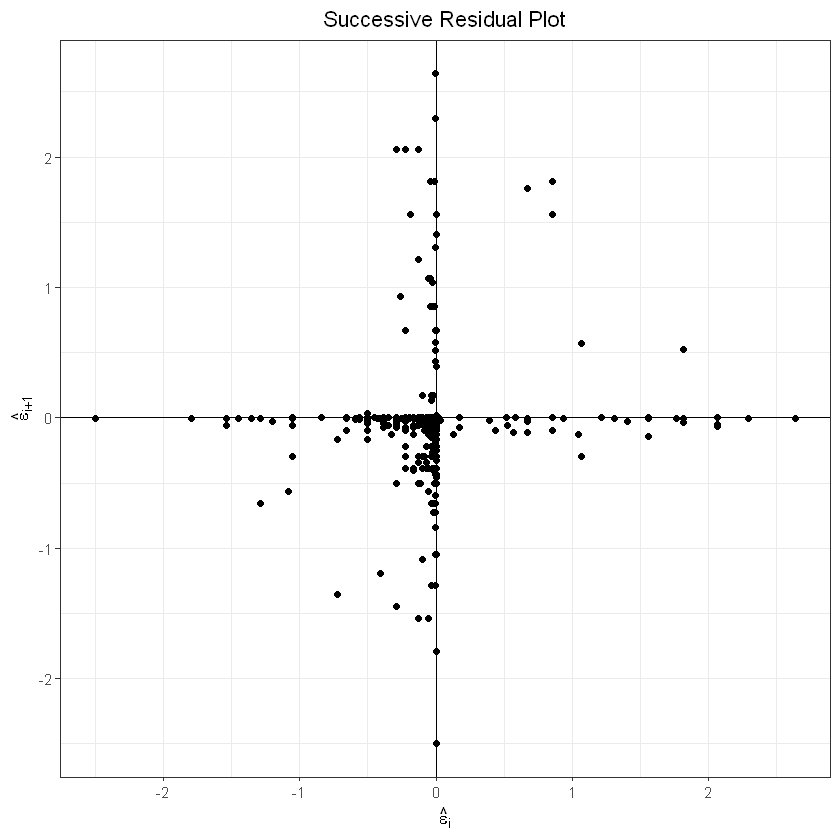

In [32]:
# full dataset - champion
diagnostics_plots(df=train_full_champion, model=glmod_full_champion, response_var='Champion', type='response')

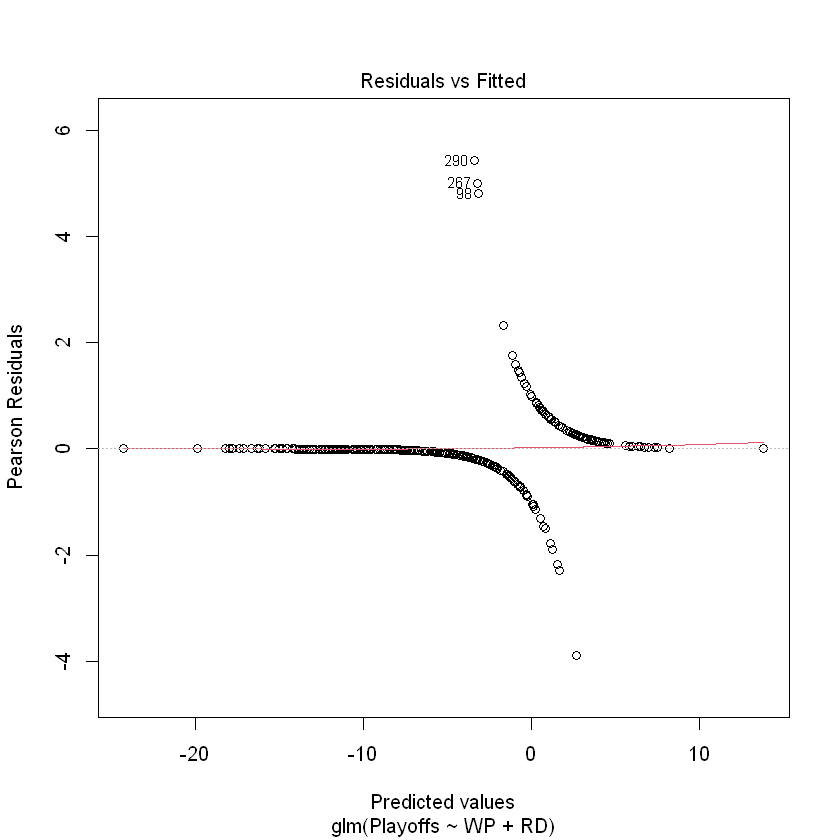

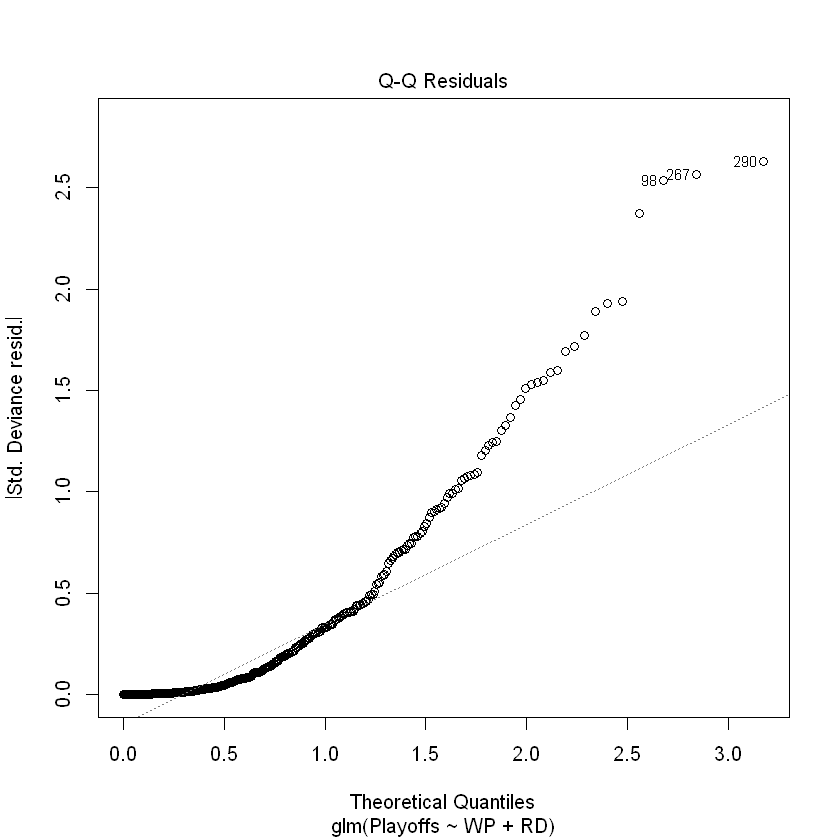

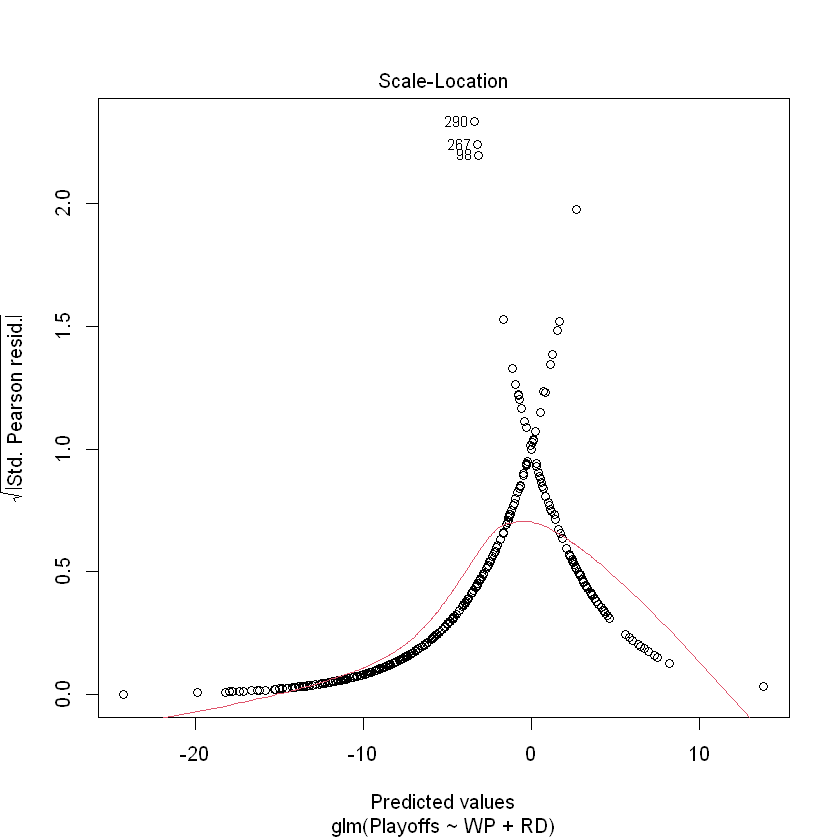

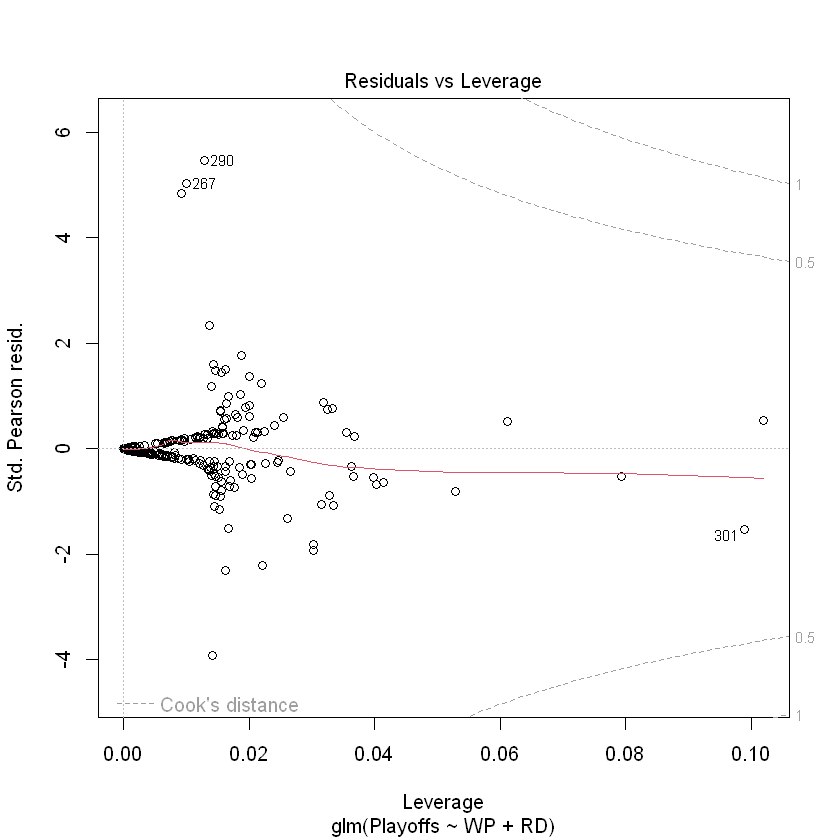

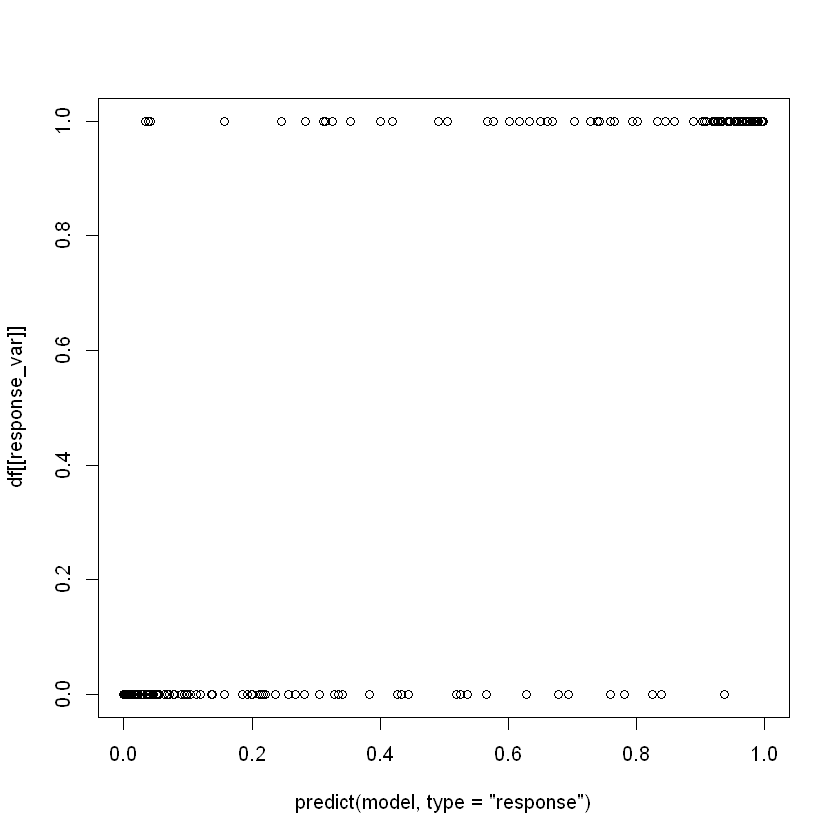

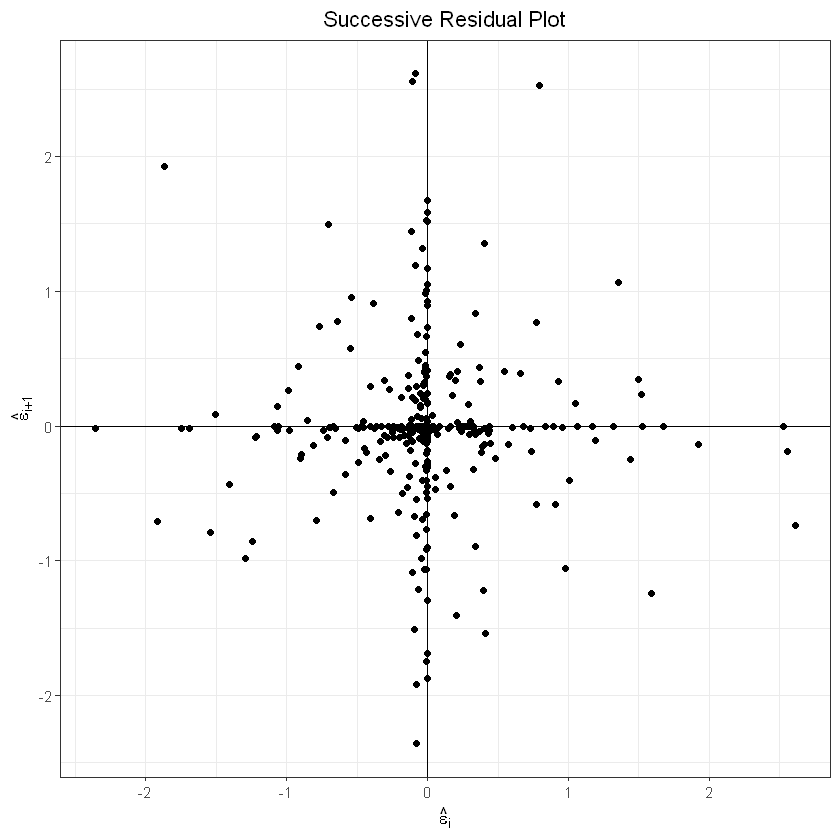

In [33]:
# recent dataset - playoffs
diagnostics_plots(df=train_recent_playoffs, model=glmod_recent_playoffs, response_var='Playoffs', type='response')

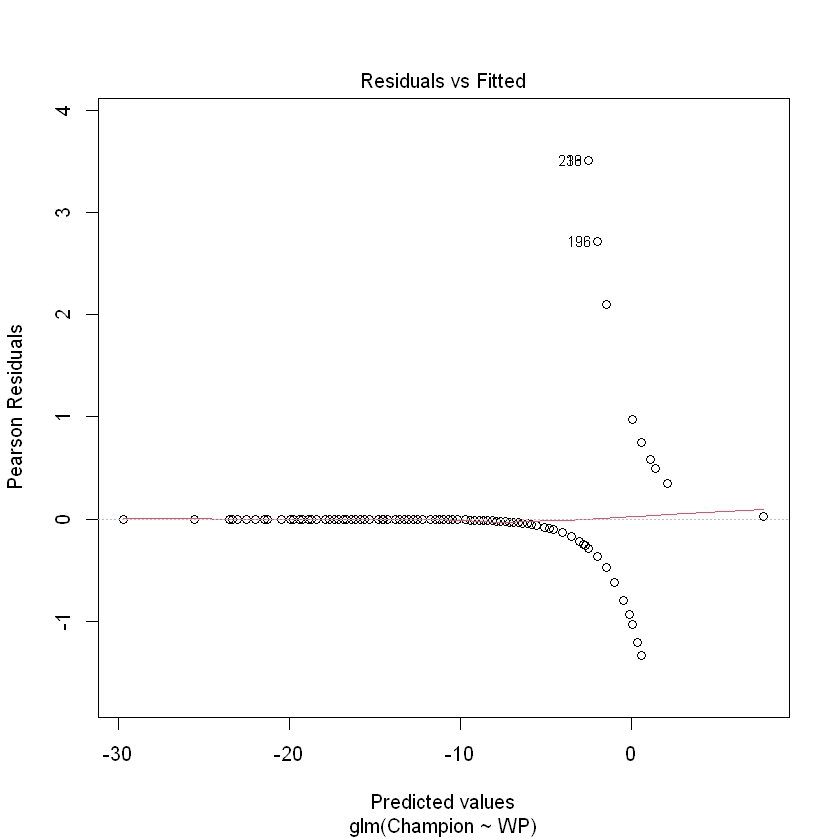

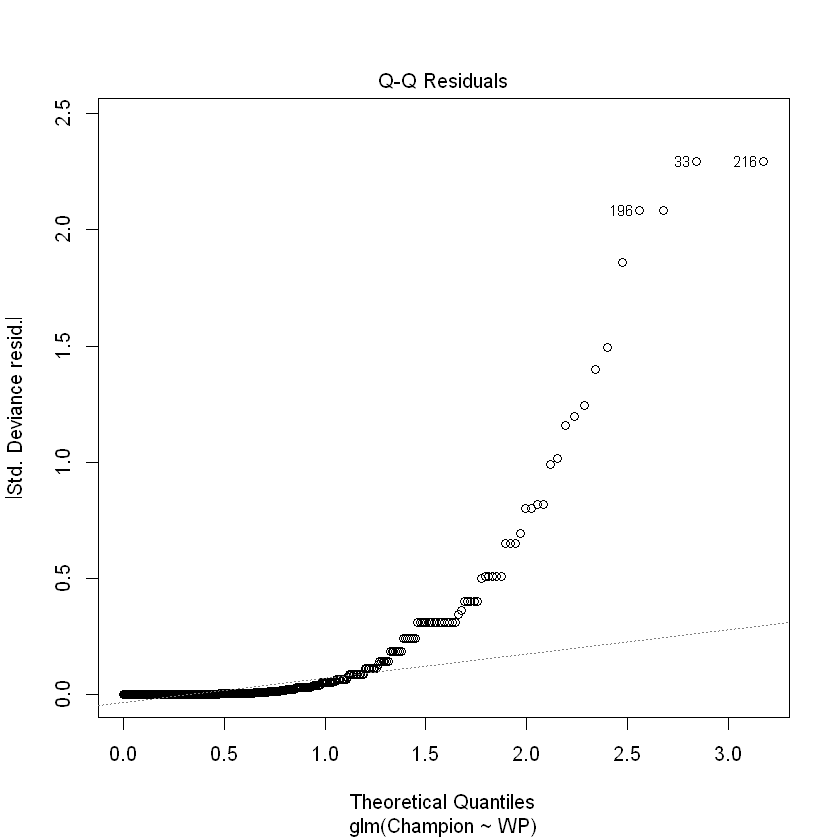

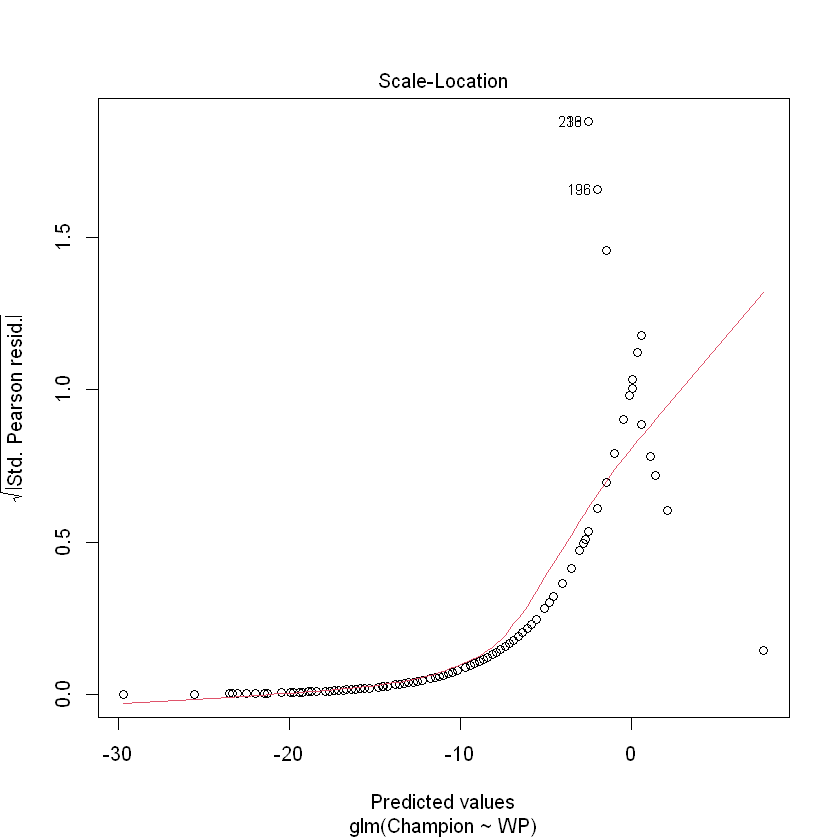

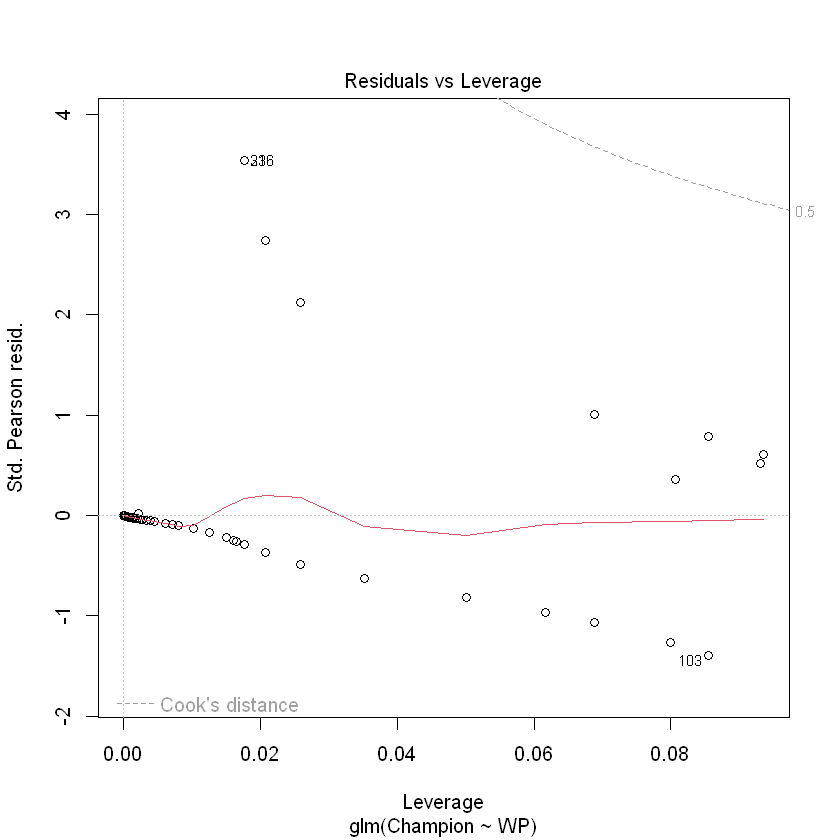

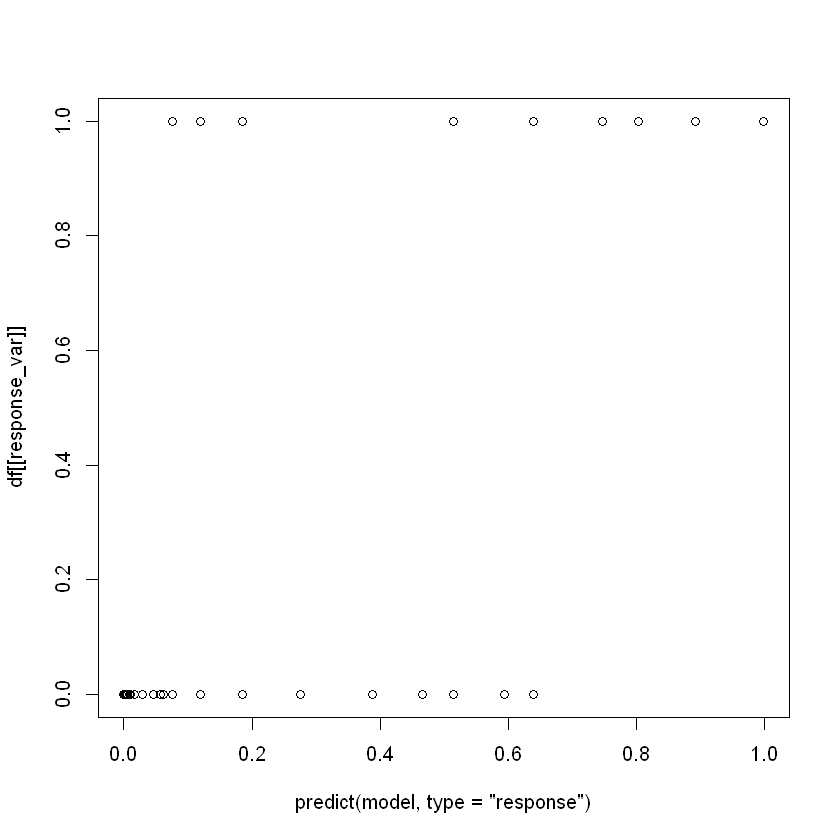

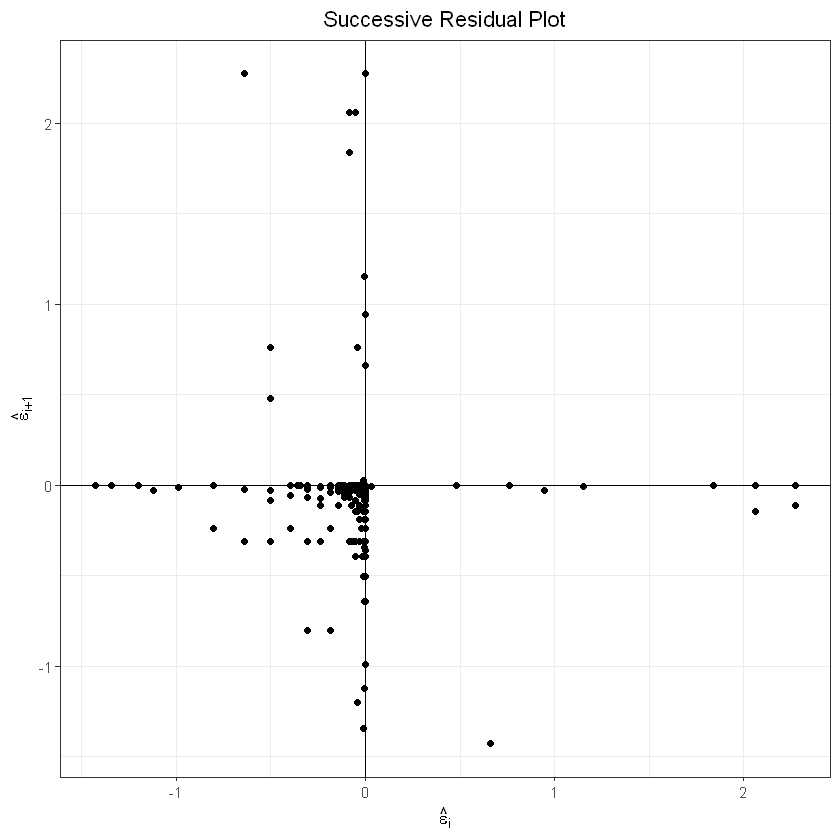

In [34]:
# recent dataset - champion
diagnostics_plots(df=train_recent_champion, model=glmod_recent_champion, response_var='Champion', type='response')

# Comments on Diagnostic Plots

# Collinearity

In [36]:
# full dataset - playoffs
print('Full Dataset - Playoffs')
vif(glmod_full_playoffs)
# full dataset - champion
print('Full Dataset - Champion: has only 1 variable')
# vif(glmod_full_champion)
# recent dataset - playoffs
print('Recent Dataset - Playoffs')
vif(glmod_recent_playoffs)
# recent dataset - champion
print('Recent Dataset - Champion: has only 1 variable')
# vif(glmod_recent_champion)

[1] "Full Dataset - Playoffs"


SLG       WP 
1.013629 1.013629

[1] "Full Dataset - Champion: has only 1 variable"
[1] "Recent Dataset - Playoffs"


WP       RD 
2.287642 2.287642

[1] "Recent Dataset - Champion: has only 1 variable"


# Comments on Collinearity